# CPU Acceleration of Mandelbrot Generation
In this example we use numba to accelerate the generation of the Mandelbrot set.
The numba package allows us to compile python bytecode directly to machine instructions.
It uses the LLVM compiler under the hood to compile optimized native code on the fly.


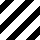
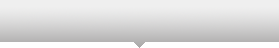
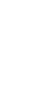
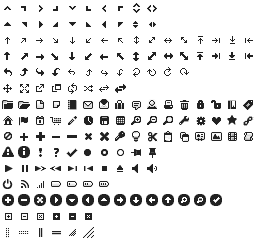
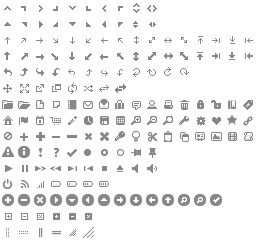
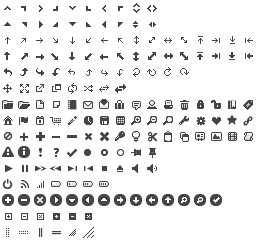
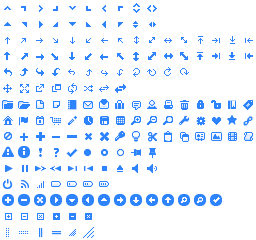
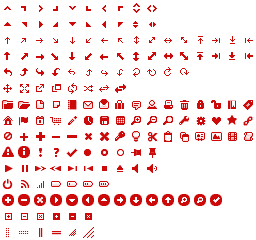
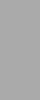
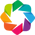
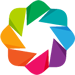
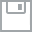
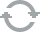
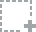
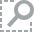
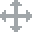
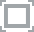
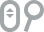

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [1]:
import numpy as np
import bokeh.plotting as bk
bk.output_notebook()
from numba import jit
from timeit import default_timer as timer
from IPython.html.widgets import interact, interact_manual, fixed, FloatText

Recall that the Mandelbrot set is the set of complex numbers $c$ for which
the sequence $z_n$ stays bounded, where the sequence start from $z_0 = 0$ 
and is generated from the map
$$ z_{n+1} = z_n^2 + c.$$

First we'll make a function to calculate how long before the sequence 
$z \rightarrow z^2 + c$ diverges.
As the condition for divergence, we'll check to see when $|z|^2 > 4$.
We will limit the check to some number `max_iters`, perhaps 255.

In [2]:
@jit(nopython=True)
def mandel(x, y, max_iters):
    """
    Return the number of iterations for the complex
    sequence z -> z**2 + c to exceed 2.0, where c = x + iy.
    """
    c = complex(x, y)
    z = 0j
    for i in range(max_iters):
        z = z**2 + c
        if (z.real * z.real + z.imag * z.imag > 4.0):
            return i
    return max_iters

Next we make a function to create the fracal.
It will fill a two-dimensional integer array `data` with the number of iterations before
the sequence diverged. Points inside the Mandelbrot set will have the value `max_iters`.

In [3]:
@jit(nopython=True)
def make_fractal(xmin, xmax, ymin, ymax, data, max_iters):
    height, width = data.shape
    dx = (xmax - xmin) / width
    dy = (ymax - ymin) / height
    for i in range(width):
        x = xmin + dx * (i + 0.5)
        for j in range(height):
            y = ymin + dy * (j + 0.5)
            data[j,i] = mandel(x, y, max_iters)
    return data

Now we'll generate a fractal. We'll generate an image 1536 by 1024, covering $-2 \le x\le +1$
and $-1 \le y \le +1$. 
We also put timer commands around the function call so we can see how long it took.

In [4]:
N = 768, 512
data = np.zeros(N, np.uint8)
xmin, xmax, ymin, ymax = -2.0, 1.0, -1.0, 1.0
start = timer()
make_fractal(xmin, xmax, ymin, ymax, data, 255)
end = timer()
print("Generated fractal image in {time:.3f} ms".format(time = 1000 * (end - start)))

Generated fractal image in 460.937 ms


In [5]:
fig = bk.figure(x_range=[xmin, xmax], y_range=[ymin, ymax], width=768, height=512)
fig.image(image=[data], x=[xmin], y=[ymin], dw=[xmax-xmin], dh=[ymax-ymin], palette="YlOrBr9")
bk.show(fig)

We can make this recalculate interactively by creating a function that returns a plot.
Since we want to zoom over many orders of magnitude, the function arguments will be the center (x,y) and base-10 logarithm of the scale.

In [6]:
def calculate_plot(x, y, logscale):
    width = 3 * 10 ** logscale
    height = 2 * 10 ** logscale
    xmin, xmax = x - width/2, x + width/2
    ymin, ymax = y - height/2, y + height/2
    start = timer()
    make_fractal(xmin, xmax, ymin, ymax, data, 255)
    end = timer()
    print("Generated fractal image in {time:.3f} ms".format(time = 1000 * (end - start)))
    fig = bk.figure(x_range=[xmin, xmax], y_range=[ymin, ymax], width=768, height=512)
    fig.image(image=[data], x=[xmin], y=[ymin], dw=[xmax-xmin], dh=[ymax-ymin], palette="YlOrBr9")
    bk.show(fig)


In [7]:
calculate_plot(-1.4,0,-2)

Generated fractal image in 341.711 ms


In [8]:
calculate_plot(-1.405,0,-7)

Generated fractal image in 561.642 ms


Using IPython widgets and the ”interact_manual” command, we can make this more interactive. Note that most of the delay is the time to send the generate the graphical image and send it from the server. As you zoom in, round-off error in the floating point precision of the math will cause numerical artifacts.

In [9]:
interact_manual(calculate_plot, x=FloatText(-0.003001005), y=FloatText(0.64400092), logscale=(-8,0,0.1))

Generated fractal image in 410.664 ms
